In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode

import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

/home/ricardo/miniconda3/envs/CEM-detectron/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pretrained DBT detector

In [3]:
config_file = str(repo_path / 'data/models/config_trained_R_101_30k.yaml')
model_file = str(repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth')
min_score = 1e-5 # minimum score to keep prediction

# load trained network 
cfg = get_cfg()
cfg.merge_from_file(config_file)
#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = model_file
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = min_score #0.8  # set the testing threshold for this model
# define predictor
predictor = DefaultPredictor(cfg)

In [4]:
# settings
substracted_dir = repo_path / 'data/CDD-CESM/images/substracted'
bbox_dataframe = pd.read_csv(repo_path / 'data/CDD-CESM/masks/bbox_CESM.csv')
# filter by patient num
pat_id_ex = bbox_dataframe['patient_id'].unique()[0]
pat_bboxes = bbox_dataframe[bbox_dataframe['patient_id']==pat_id_ex]

# show the bboxes
print(pat_bboxes)

row = pat_bboxes.iloc[9]
im_name = row['image_name']
region_id = row['region_id']
bbox = eval(row['bbox'])

# read image
im_path = substracted_dir / f'{im_name}.jpg'
im_array = cv.imread(str(im_path))

Patient 2 is selected
    patient_id   image_name  region_id                    bbox
0            2   P2_R_CM_CC          0   (536, 2083, 355, 307)
1            2   P2_R_CM_CC          1   (633, 1620, 411, 283)
2            2   P2_R_CM_CC          2   (347, 1233, 307, 211)
3            2   P2_R_CM_CC          3    (629, 750, 129, 129)
4            2   P2_R_CM_CC          4   (738, 1161, 153, 153)
5            2   P2_R_CM_CC          5    (321, 740, 207, 215)
6            2   P2_R_CM_CC          6    (254, 1781, 97, 137)
7            2   P2_R_CM_CC          7   (307, 1051, 113, 147)
8            2   P2_R_CM_CC          8   (927, 2081, 171, 219)
9            2  P2_R_CM_MLO          0   (828, 2016, 327, 301)
10           2  P2_R_CM_MLO          1  (1069, 1748, 253, 171)
11           2  P2_R_CM_MLO          2   (642, 2264, 139, 123)
12           2  P2_R_CM_MLO          3   (346, 1499, 293, 197)
13           2  P2_R_CM_MLO          4   (888, 1558, 233, 233)
14           2  P2_R_CM_MLO      

Boxes(tensor([[ 794.2234, 1982.9661, 1174.0612, 2340.4226],
        [ 598.4744, 1180.6650,  731.6143, 1322.5007],
        [ 337.4671, 1184.8337,  441.3352, 1293.0646],
        [ 284.0463, 1158.2733,  680.9235, 1680.6018],
        [ 750.2966,  893.7874, 1404.7534, 2507.4419],
        [ 763.2040, 1693.2090, 1285.1968, 2348.8909],
        [ 317.7639, 1183.1108,  449.1468, 1354.4812],
        [ 306.3513, 1202.4442,  545.2087, 1550.3861],
        [ 339.9773, 1358.6129, 1328.0468, 2357.2122],
        [ 881.7174,  260.0940, 1432.3547, 2189.7898]]))


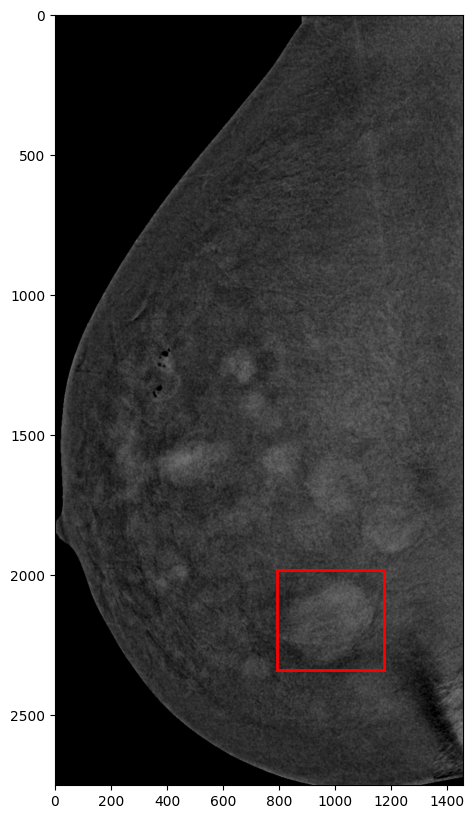

In [47]:
# predict bbox
outputs = predictor(im_array)
out = outputs["instances"].to("cpu")
print(out.pred_boxes)


box_num = 0
topLeftX = out.pred_boxes.tensor[box_num][0]
topLeftY = out.pred_boxes.tensor[box_num][1]
bottomRightX = out.pred_boxes.tensor[box_num][2]
bottomRightY = out.pred_boxes.tensor[box_num][3]

bbox = patches.Rectangle((topLeftX, topLeftY), bottomRightX - topLeftX, bottomRightY - topLeftY,
                        linewidth=2, edgecolor='r', facecolor='none')

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(im_array, cmap='gray')
ax.add_patch(bbox)
plt.show()
